In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

import seaborn as sns
import json

from utils import read_data,fitted_mu,fit_mu_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
idx_list = [i for i in range(48)]

In [3]:
N_list = [n for n in range(11,18)]
def get_path(N,idx):
    return f'distribution/max_k_colorable/n{N}_k3/{idx}.npy'
df_mkcs = read_data(N_list,idx_list,get_path,num_processes=4)

100%|██████████| 336/336 [00:00<00:00, 391.73it/s]


In [4]:
N_list = [n for n in range(16,29,2)]
def get_path(N,idx):
    return f'distribution/maxcut/n{N}/{idx}.npy'
df_mc = read_data(N_list,idx_list,get_path,num_processes=4)

100%|██████████| 336/336 [00:00<00:00, 421.40it/s]


In [5]:
N_list = [n for n in range(18,31,2)]
def get_path(N,idx):
    return f'distribution/max_k_vertex_cover/n{N}/{idx}.npy'
df_mkvc = read_data(N_list,idx_list,get_path,num_processes=4)

100%|██████████| 336/336 [00:00<00:00, 389.65it/s]


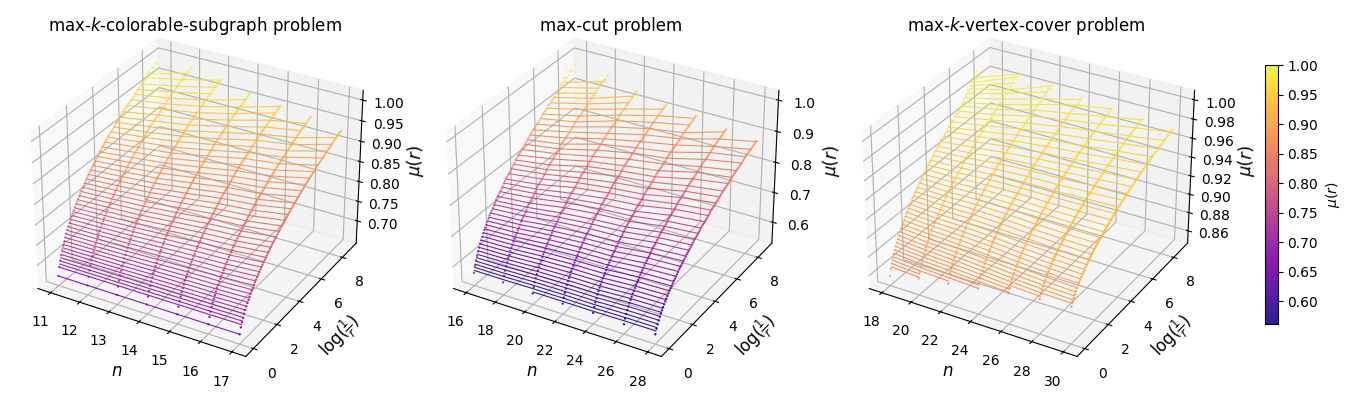

In [6]:
df_list = [df_mkcs, df_mc, df_mkvc] 
titles = [r'max-$k$-colorable-subgraph problem', 'max-cut problem', r'max-$k$-vertex-cover problem']

fig, ax_list = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={'projection': '3d'})
cmap = plt.get_cmap('plasma')

target_v_list = []

for df in df_list:
    N_unique = np.sort(df['N'].unique())
    log1r_unique = np.sort(df['log(1/r)'].unique())
    log1r_unique = log1r_unique.reshape(100, 8)[:, 0]
    N, log1r = np.meshgrid(N_unique, log1r_unique)
    
    results = np.empty(N.shape)
    for i in range(len(log1r_unique)):
        for j in range(len(N_unique)):
            result_value = np.mean(df[(df['N'] == N_unique[j]) & (df['log(1/r)'] == log1r_unique[i])]["approxUB"].values)
            results[i, j] = result_value
    
    target_v_list.append(np.linspace(np.min(results), 1, 51)[0:-1])

min_v = min([np.min(target_v) for target_v in target_v_list])
max_v = 1
norm = plt.Normalize(min_v, max_v)

for idx, df in enumerate(df_list):
    N_unique = np.sort(df['N'].unique())
    log1r_unique = np.sort(df['log(1/r)'].unique())
    log1r_unique = log1r_unique.reshape(100, 8)[:, 0]
    N, log1r = np.meshgrid(N_unique, log1r_unique)

    results = np.empty(N.shape)
    for i in range(len(log1r_unique)):
        for j in range(len(N_unique)):
            result_value = np.mean(df[(df['N'] == N_unique[j]) & (df['log(1/r)'] == log1r_unique[i])]["approxUB"].values)
            results[i, j] = result_value

    target_v = np.linspace(np.min(results), 1, 51)[0:-1]

    mem = []
    for v in target_v:
        x = []
        y = []
        z = []
        mem_v = []
        for i in range(len(N_unique)):
            for j in range(len(log1r_unique) - 1):
                if results[j, i] <= v <= results[j + 1, i]:
                    if [j, j + 1] not in mem:
                        x.append(N_unique[i])
                        z.append(v)
                        r = (v - results[j, i]) / (results[j + 1, i] - results[j, i])
                        y.append(log1r_unique[j] + (log1r_unique[j + 1] - log1r_unique[j]) * r)
                        mem_v.append([j, j + 1])
                        break
        if len(x) > 1:
            if mem_v not in mem:
                ax_list[idx].plot3D(x, y, z, color=cmap(norm(v)), linewidth=0.8, alpha=0.9)
                mem.append(mem_v)

    N_flat = N.flatten()
    log1r_flat = log1r.flatten()
    results_flat = results.flatten()
    valid_indices = np.where(results_flat <= 1)
    N_valid = N_flat[valid_indices]
    log1r_valid = log1r_flat[valid_indices]
    results_valid = results_flat[valid_indices]
    scatter = ax_list[idx].scatter(N_valid, log1r_valid, results_valid, c=results_valid, cmap=cmap, marker='.', s=1.8, norm=norm)
    
    ax_list[idx].set_title(titles[idx], fontsize=12, y=1)
    ax_list[idx].set_xlabel(r'$n$', fontsize=12)
    ax_list[idx].set_ylabel(r'$\log(\frac{1}{r})$', fontsize=12)
    ax_list[idx].set_zlabel(r'$\mu(r)$', fontsize=12)
    ax_list[idx].grid()

fig.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
color_bar = fig.colorbar(sm, ax=ax_list, aspect=20, shrink=0.7, alpha=0.9, pad=0.034, label=r'$\mu(r)$')

plt.savefig('./figs/mu_r.pdf')

plt.show()


In [7]:
params_approx_list = []
df_list = [df_mkcs, df_mc, df_mkvc] 
titles = [r'max-$k$-colorable-subgraph problem', 'max-cut problem', r'max-$k$-vertex-cover problem']
for idx, df in enumerate(df_list):
    if idx == 2:
        fitting_init = [0.1,0.1,0.9,0.1,0.1]
    else:
        fitting_init = [0.1,0.1]
    params_approx,mse = fit_mu_model(df[df['approxUB']<1],fitting_init)
    print(titles[idx],params_approx,mse)
    params_approx_list.append(params_approx)

max-$k$-colorable-subgraph problem [7.6821692478885275, -11.19167185313419, 0.6666666666666666] 0.0002156298858427101
max-cut problem [3.6849266553278457, -8.678353828816, 0.5655290553238375] 0.0004472526706737064
max-$k$-vertex-cover problem [ 5.20735783e+01 -5.97870545e+02  8.89588225e-01  1.20330563e-01
 -6.20678634e+00] 5.054030642716131e-05


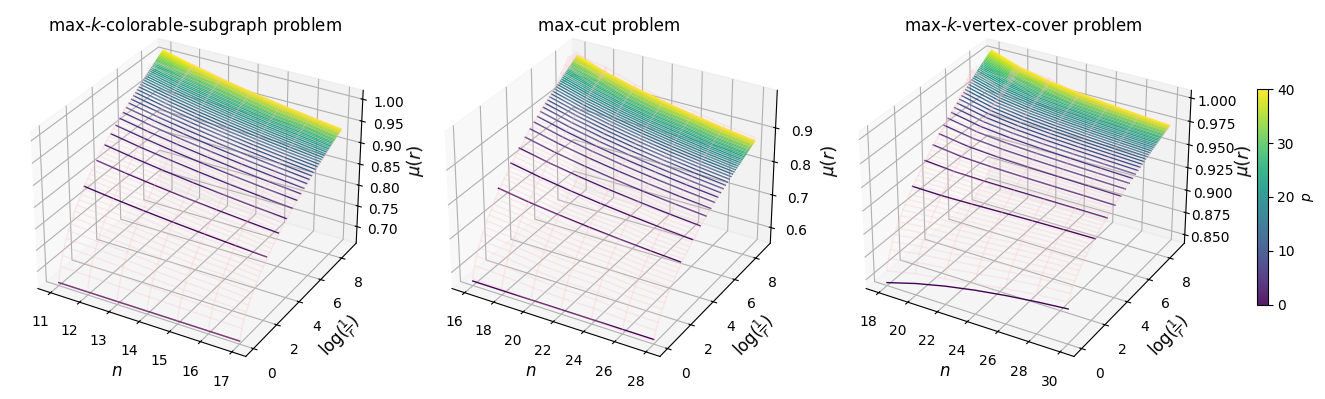

In [8]:
fig, ax_list = plt.subplots(1, 3, figsize=(20.75, 4), subplot_kw={'projection': '3d'})  # 3个子图横排排列，每个图像的宽度为6

plot_p_list = [p for p in range(41)]
norm = plt.Normalize(np.min(plot_p_list), np.max(plot_p_list))
cmap = plt.get_cmap('viridis')
    

for idx, df in enumerate(df_list):
    N_unique = np.sort(df['N'].unique())
    log1r_unique = np.sort(df['log(1/r)'].unique())
    N, log1r = np.meshgrid(N_unique, log1r_unique)
    
    results = np.empty(N.shape)
    for i in range(len(log1r_unique)):
        for j in range(len(N_unique)):
            result_value = np.mean(df[(df['N'] == N_unique[j]) & (df['log(1/r)'] == log1r_unique[i])]["approxUB"].values)
            results[i, j] = result_value
            
    masked_results = np.where(results <= 1, results, np.nan)
    ax_list[idx].plot_wireframe(N, log1r, masked_results, color='pink', alpha=0.3, linewidth=1)
    
    for p in plot_p_list:
        x = N_unique
        y = [np.log((2*p+1)**2)]*len(N_unique)
        z = [fitted_mu(n,p,params_approx_list[idx]) for n in N_unique]
        ax_list[idx].plot3D(x, y, z, color=cmap(norm(p)),linewidth=1)

    ax_list[idx].set_title(titles[idx], fontsize=12, y=1)
    ax_list[idx].set_xlabel(r'$n$', fontsize=12)
    ax_list[idx].set_ylabel(r'$\log(\frac{1}{r})$', fontsize=12)
    ax_list[idx].set_zlabel(r'$\mu(r)$', fontsize=12)
    ax_list[idx].grid()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
color_bar = fig.colorbar(sm, ax=ax_list, aspect=20, shrink=0.7, alpha=0.9, pad=-0.45, label=r'$p$')

fig.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.savefig('./figs/mu_r_p.pdf')

plt.show()
